Jonathan McEntee - September 9th 2018

Things that need to be done:
 - Find two "interesting" datasets. Aka, datasets that don't train exactly the same accuracy
 - Explain the cars dataset classification problem and why you feel its interesting
 - Write an introduction to the second dataset (digits?)
 - Fix the cross_validation v training graphs
 - Measure the time it takes to run each algorithm, also under different circumstances
 - Perform analysis on datasets/algorithms including:
  - how fast each model ran
  - which algorithm performed best
  - how do you define best?
  - analysis of why you chose different hyperparameter options

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import timeit
import graphviz
import warnings

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, validation_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

warnings.filterwarnings("once")

# Adult Data Set

In [ ]:
adult_data = pd.read_csv('adult.csv')
adult_data.head()

FileNotFoundError: File b'adult.csv' does not exist

In [ ]:
len(adult_data)

In [ ]:
subsampled_adult_data = adult_data.sample(n=6000, random_state=42)
len(subsampled_adult_data)

In [ ]:
subsampled_adult_data.income.value_counts()

In [ ]:
dummified_data = pd.get_dummies(subsampled_adult_data,
                                columns=["workclass", "education", "marital_status",
                                         "occupation", "relationship", "race", "sex",
                                         "native_country"])

dummified_data.head()

In [ ]:
y = dummified_data["income"]
X = dummified_data.drop(["income"], axis=1)

In [ ]:
y.value_counts()

In [73]:
1453 / (4547 + 1453)

0.24216666666666667

## Create Test and Training Sets

In [34]:
y_train, y_test = train_test_split(y, test_size=0.1, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.1, stratify=y, random_state=42)

## Functions

In [35]:
def learning_curve_dataframe(estimator, X, y, train_sizes=np.linspace(.1, 1.0, 10),
                             cv=None, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    test_score_df = pd.DataFrame(dict(train_sizes=train_sizes,
                                      score_mean=np.mean(train_scores, axis=1),
                                      score_std=np.std(train_scores, axis=1),
                                      score_type="Training score"))
    
    train_score_df = pd.DataFrame(dict(train_sizes=train_sizes,
                                       score_mean=np.mean(test_scores, axis=1),
                                       score_std=np.std(test_scores, axis=1),
                                       score_type="Cross-validation score"))
    
    return pd.concat([test_score_df, train_score_df])

def plot_learning_curve(title, df, ylim=None):
    """
    taken from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    
    training_score = df[df.score_type == "Training score"]
    train_sizes = training_score.train_sizes
    train_scores_mean = training_score.score_mean
    train_scores_std = training_score.score_std
    
    test_score = df[df.score_type == "Cross-validation score"]
    test_scores_mean = test_score.score_mean
    test_scores_std = test_score.score_std
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def validation_curve_dataframe(estimator, X, y, cv=None, n_jobs=-1, param_name=None,
                               param_range=np.linspace(1, 100, 10), alternative_x_axis=None):
    
    x_axis = alternative_x_axis if alternative_x_axis is not None else param_range
    
    train_scores, test_scores = validation_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, param_name=param_name,
        param_range=param_range)
    
    test_score_df = pd.DataFrame(dict(parameter_setting=x_axis,
                                      score_mean=np.mean(train_scores, axis=1),
                                      score_std=np.std(train_scores, axis=1),
                                      score_type="Training score",
                                      graph_type="Validation Curve"))
    
    train_score_df = pd.DataFrame(dict(parameter_setting=x_axis,
                                       score_mean=np.mean(test_scores, axis=1),
                                       score_std=np.std(test_scores, axis=1),
                                       score_type="Cross-validation score",
                                       graph_type="Validation Curve"))
    
    return pd.concat([test_score_df, train_score_df])

def plot_validation_curve(title, df, ylim=None, xlab=None, log=False):
    
    training_score = df[df.score_type == "Training score"]
    x_axis = training_score.parameter_setting
    train_scores_mean = training_score.score_mean
    train_scores_std = training_score.score_std
    
    test_score = df[df.score_type == "Cross-validation score"]
    test_scores_mean = test_score.score_mean
    test_scores_std = test_score.score_std
    
    xlab = "Parameter Setting" if xlab is None else xlab
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlab)
    plt.ylabel("Score")
    plt.grid()

    if log:
        plt.xscale("log")
    
    plt.fill_between(x_axis, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(x_axis, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(x_axis, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(x_axis, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


## Using a Decision Tree Classifier

In [10]:
parameters = {
    'max_depth' : list(range(1, 30, 2)),
    'min_samples_split' : list(range(20, 1000, 10))
}

decision_tree = DecisionTreeClassifier()
clf = GridSearchCV(decision_tree, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 9, 'min_samples_split': 640}

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

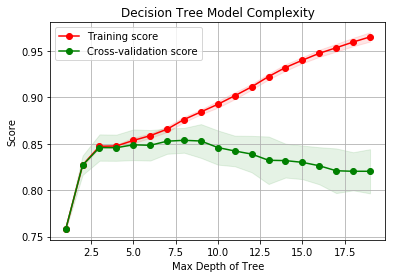

In [40]:
# built in validation curve
clf = DecisionTreeClassifier(min_samples_split=2)
df = validation_curve_dataframe(estimator=clf, X=X_train, y=y_train, cv=10,
                                param_name='max_depth', param_range=range(1, 20))
validation_dataframes = df.assign(model_name='Decision Tree', parameter_name='Max Depth of Tree')
plot_validation_curve(title="Decision Tree Model Complexity", df=df,
                     xlab="Max Depth of Tree")

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

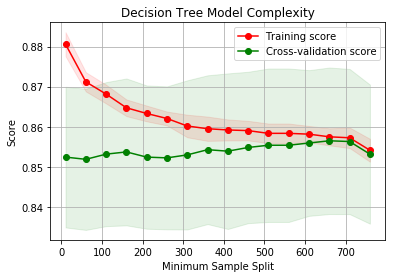

In [10]:
clf = DecisionTreeClassifier(max_depth=9)
df = validation_curve_dataframe(estimator=clf,
                           X=X_train, y=y_train, param_name='min_samples_split',
                           param_range=range(10, 800, 50), cv=10)
validation_dataframes = pd.concat([df.assign(model_name='Decision Tree', parameter_name='Minimum Sample Split'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="Decision Tree Model Complexity", xlab="Minimum Sample Split", df=df)

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

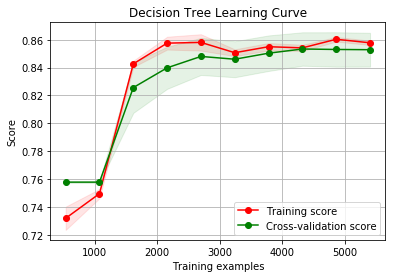

In [11]:
clf = DecisionTreeClassifier(max_depth=9, min_samples_split=650)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
learning_curve_dataframes = df.assign(model_name="Decision Tree")
plot_learning_curve(title="Decision Tree Learning Curve", df=df)

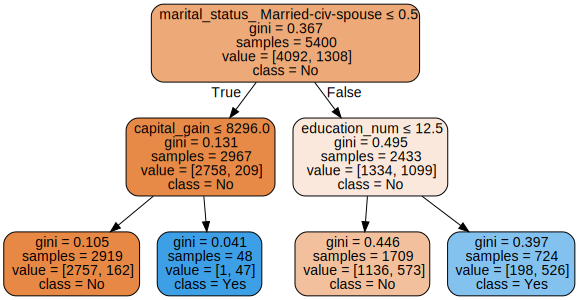

In [12]:
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=40)
clf.fit(X_train, y_train)
dot_data = export_graphviz(clf, out_file=None,  
                         feature_names=X.columns,
                         class_names = ['No', 'Yes'],
                         filled=True, rounded=True,  
                         special_characters=True)  

graphviz.Source(dot_data)

In [36]:
start = timeit.default_timer()
clf = DecisionTreeClassifier(max_depth=4, min_samples_split=60)
clf.fit(X_train, y_train)
decision_tree_train_time = timeit.default_timer() - start
decision_tree_train_time

0.03050486001302488

In [37]:
start = timeit.default_timer()
decision_tree_score = clf.score(X_test, y_test)
decision_tree_score_time = timeit.default_timer() - start
decision_tree_score_time

0.0035229680070187896

In [38]:
model_scores = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                             'score_value': [decision_tree_train_time,
                                             decision_tree_score_time,
                                             decision_tree_score],
                             'model' : 'Decision Tree'
                            })

## Using K Nearest Neighbors

In [26]:
parameters = {
    'n_neighbors' : list(range(1, 30)),
    'weights' : ['uniform', 'distance'],
    "p" : [1, 2]
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'n_neighbors': 17, 'p': 2, 'weights': 'uniform'}

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

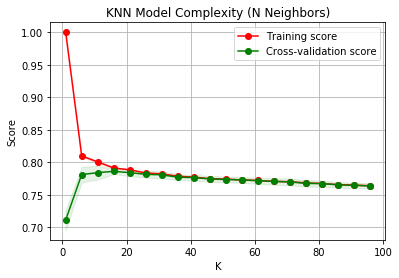

In [16]:
clf = KNeighborsClassifier(p=2)
df = validation_curve_dataframe(estimator=clf,
                                X=X_train, y=y_train,
                                param_name='n_neighbors', param_range=range(1, 100, 5),
                                cv=10)
validation_dataframes = pd.concat([df.assign(model_name='K Nearest Neighbors', parameter_name='K'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="KNN Model Complexity (N Neighbors)", df=df, xlab="K")

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

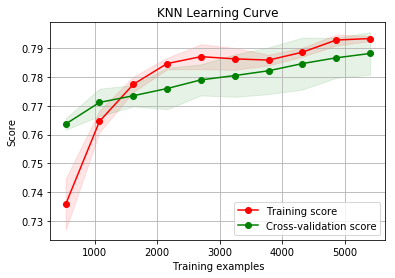

In [17]:
# the built in learning curve
clf = KNeighborsClassifier(p=2, n_neighbors=17)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
learning_curve_dataframes = pd.concat([df.assign(model_name="K Nearest Neighbors"),
                                       learning_curve_dataframes], sort=True)
plot_learning_curve(title="KNN Learning Curve", df=df)

In [39]:
start = timeit.default_timer()
clf = KNeighborsClassifier(p=2, n_neighbors=17)
clf.fit(X_train, y_train)
knn_train_time = timeit.default_timer() - start
knn_train_time

0.03451940300874412

In [40]:
start = timeit.default_timer()
knn_score = clf.score(X_test, y_test)
knn_score_time = timeit.default_timer() - start
knn_score_time

0.04754938097903505

In [41]:
df = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                   'score_value': [knn_train_time,
                                   knn_score_time,
                                   knn_score],
                   'model' : 'K Nearest Neighbors'
                  })
model_scores = pd.concat([model_scores, df])

## Using AdaBoost

In [27]:
parameters = {
    'n_estimators' : list(range(20, 80)),
    'learning_rate' : [10**x for x in range(-1, 2)],
}

ada_booster = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=640))
clf = GridSearchCV(ada_booster, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'learning_rate': 0.1, 'n_estimators': 77}

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

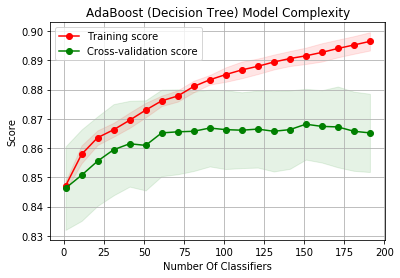

In [15]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=640), learning_rate=0.1)
df = validation_curve_dataframe(estimator=clf,
                                X=X_train, y=y_train,
                                param_name='n_estimators', param_range=range(1, 200, 10),
                                cv=10)
#validation_dataframes = pd.concat([df.assign(model_name='AdaBoost', parameter_name='Number of Classifiers'),
#                                   validation_dataframes], sort=True)
plot_validation_curve(title="AdaBoost (Decision Tree) Model Complexity", df=df,
                      xlab="Number Of Classifiers")

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

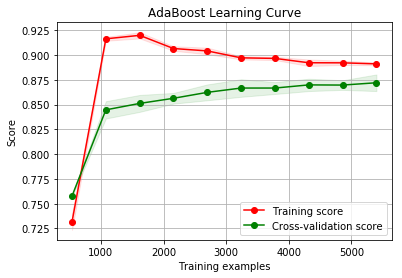

In [16]:
# the built in learning curve
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=640),
                         learning_rate=0.1, n_estimators=150)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
#learning_curve_dataframes = pd.concat([df.assign(model_name="AdaBoost"),
#                                       learning_curve_dataframes], sort=True)
plot_learning_curve(title="AdaBoost Learning Curve", df=df)

In [42]:
start = timeit.default_timer()
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=640),
                         learning_rate=0.1, n_estimators=150)
clf.fit(X_train, y_train)
adaboost_train_time = timeit.default_timer() - start
adaboost_train_time

4.745301696995739

In [43]:
start = timeit.default_timer()
adaboost_score = clf.score(X_test, y_test)
adaboost_score_time = timeit.default_timer() - start
adaboost_score_time

0.043883627018658444

In [44]:
df = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                   'score_value': [adaboost_train_time,
                                   adaboost_score_time,
                                   adaboost_score],
                   'model' : 'AdaBoost'
                  })
model_scores = pd.concat([model_scores, df])

## Using a Neural Net

In [28]:
parameters = {
    'hidden_layer_sizes' : [tuple([x] * n) for x in range(10,100,10) for n in range(1,5)],
    'max_iter' : range(200, 500, 100)
}

# 'max_iter' : range(200, 500, 50),

mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'hidden_layer_sizes': (90,), 'max_iter': 300}

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

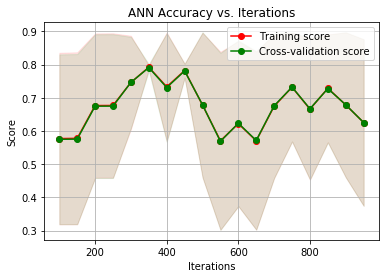

In [27]:
clf = MLPClassifier(hidden_layer_sizes=(90), tol=1e-1000)
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y,
                                param_name='max_iter', param_range=range(100, 1000, 50),
                                cv=10)
#validation_dataframes = pd.concat([df.assign(model_name='Neural Net', parameter_name='Iterations'),
#                                   validation_dataframes], sort=True)
plot_validation_curve(title="ANN Accuracy vs. Iterations", df=df,
                      xlab="Iterations")

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

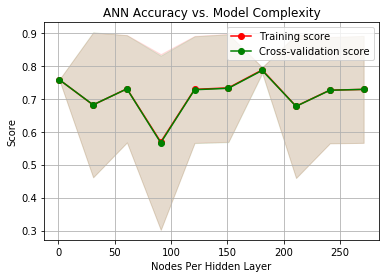

In [24]:
clf = MLPClassifier(max_iter=300)
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y,
                                param_name='hidden_layer_sizes',
                                param_range=[tuple([x] * 3) for x in range(1, 300, 30)],
                                alternative_x_axis=range(1, 300, 30), cv=10)
#validation_dataframes = pd.concat([df.assign(model_name='Neural Net', parameter_name='Nodes Per Hidden Layer'),
#                                   validation_dataframes], sort=True)
plot_validation_curve(title="ANN Accuracy vs. Model Complexity", df=df,
                      xlab="Nodes Per Hidden Layer")

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

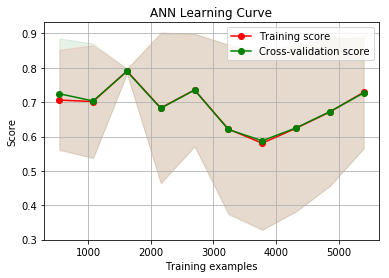

In [26]:
# the built in learning curve
clf = MLPClassifier(hidden_layer_sizes=(90), max_iter=300)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
#learning_curve_dataframes = pd.concat([df.assign(model_name="Neural Net"),
#                                       learning_curve_dataframes], sort=True)
plot_learning_curve(title="ANN Learning Curve", df=df)

In [1]:
start = timeit.default_timer()
clf = MLPClassifier(hidden_layer_sizes=(90), max_iter=300)
clf.fit(X_train, y_train)
ann_train_time = timeit.default_timer() - start
ann_train_time

NameError: name 'timeit' is not defined

In [46]:
start = timeit.default_timer()
ann_score = clf.score(X_test, y_test)
ann_score_time = timeit.default_timer() - start
ann_score_time

0.006895000988151878

In [47]:
df = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                   'score_value': [ann_train_time,
                                   ann_score_time,
                                   ann_score],
                   'model' : 'Neural Net'
                  })
model_scores = pd.concat([model_scores, df])

## Using a Support Vector Machine (rbf)

In [30]:
parameters = {
    'C' : [10**x for x in range(-3, 5)],
    'kernel' : ['rbf'],
    'gamma' : [10**x for x in range(-3, 5)]
}

svc = SVC()
clf = GridSearchCV(svc, parameters, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

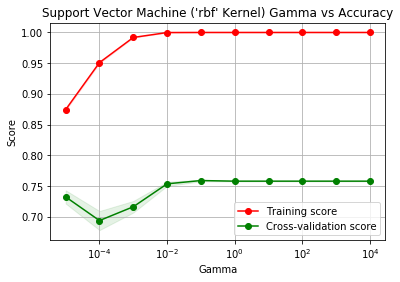

In [32]:
clf = SVC(kernel='rbf', C=10)
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y, cv=10, param_name='gamma',
                                param_range=[10**x for x in range(-5, 5)])
validation_dataframes = pd.concat([df.assign(model_name='SVM ("rbf" Kernel)', parameter_name='Gamma'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="Support Vector Machine ('rbf' Kernel) Gamma vs Accuracy", df=df,
                      xlab="Gamma", log=True)

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

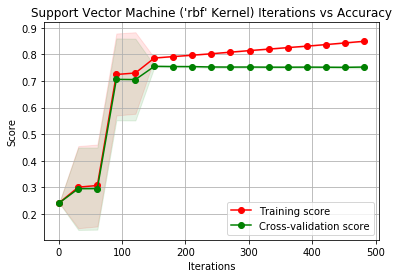

In [33]:
warnings.filterwarnings("ignore")
clf = SVC(kernel='rbf', C=10)
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y, cv=10, param_name='max_iter',
                                param_range=range(1, 500, 30))
validation_dataframes = pd.concat([df.assign(model_name='SVM ("rbf" Kernel)', parameter_name='Iterations'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="Support Vector Machine ('rbf' Kernel) Iterations vs Accuracy", df=df,
                      xlab="Iterations")

In [68]:
clf = SVC(kernel='rbf', C=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
sum(predictions == ' <=50K') / len(predictions)

0.9716666666666667

In [34]:
warnings.filterwarnings("once")

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceW

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

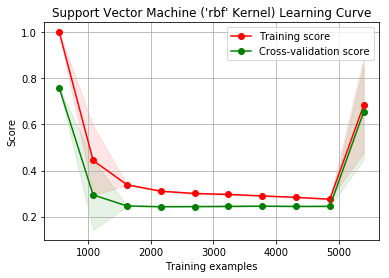

In [35]:
clf = SVC(kernel='rbf', C=10, gamma=0.1, max_iter=150)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
learning_curve_dataframes = pd.concat([df.assign(model_name='Support Vector Machine (RBF)'),
                                       learning_curve_dataframes], sort=True)
plot_learning_curve(title="Support Vector Machine ('rbf' Kernel) Learning Curve", df=df)

In [48]:
start = timeit.default_timer()
clf = SVC(kernel='rbf', C=10)
clf.fit(X_train, y_train)
svm_rbf_train_time = timeit.default_timer() - start
svm_rbf_train_time

5.820139357005246

In [49]:
start = timeit.default_timer()
svm_rbf_score = clf.score(X_test, y_test)
svm_rbf_score_time = timeit.default_timer() - start
svm_rbf_score_time

0.4054845120117534

In [50]:
df = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                   'score_value': [svm_rbf_train_time,
                                   svm_rbf_score_time,
                                   svm_rbf_score],
                   'model' : 'Support Vector Machine (RBF)'
                  })
model_scores = pd.concat([model_scores, df])

## Using a Support Vector Machine (linear)

In [31]:
parameters = {
    'C' : [10**x for x in range(-5, 5)]
}

lsvc = LinearSVC()
clf = GridSearchCV(lsvc, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'C': 0.1}

In [39]:
clf = LinearSVC(max_iter=300)
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y, cv=10, param_name='C',
                                param_range=[10**x for x in range(-5, 5)])
validation_dataframes = pd.concat([df.assign(model_name='SVM ("linear" Kernel)', parameter_name='C'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="Support Vector Machine ('linear' Kernel) C vs Accuracy", df=df,
                      xlab="C", log=True)

Process ForkPoolWorker-156:
Process ForkPoolWorker-154:
Process ForkPoolWorker-155:
Process ForkPoolWorker-153:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jonmcentee/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jonmcentee/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jonmcentee/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jonmcentee/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jonmcentee/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jonmcentee/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kw

KeyboardInterrupt: 

In [ ]:
clf = LinearSVC(C=0.1)
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y, cv=10, param_name='max_iter',
                                param_range=range(1, 600, 50))
validation_dataframes = pd.concat([df.assign(model_name='SVM ("linear" Kernel)', parameter_name='Iterations'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="Support Vector Machine ('linear' Kernel) Iterations vs Accuracy", df=df,
                      xlab="Iterations")

In [ ]:
clf = LinearSVC(C=0.1)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
learning_curve_dataframes = pd.concat([df.assign(model_name='Support Vector Machine (Linear)'),
                                       learning_curve_dataframes], sort=True)
plot_learning_curve(title="Support Vector Machine ('linear' Kernel) Learning Curve", df=df)

In [61]:
start = timeit.default_timer()
clf = LinearSVC(C=100)
clf.fit(X_train, y_train)
svm_linear_train_time = timeit.default_timer() - start
svm_linear_train_time

0.5343749750172719

In [64]:
start = timeit.default_timer()
svm_linear_score = clf.score(X_test, y_test)
svm_linear_score_time = timeit.default_timer() - start
svm_linear_score_time

0.0173594240040984

In [65]:
svm_linear_score

0.30907407407407406

In [53]:
df = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                   'score_value': [svm_linear_train_time,
                                   svm_linear_score_time,
                                   svm_linear_score],
                   'model' : 'Support Vector Machine (Linear)'
                  })
model_scores = pd.concat([model_scores, df])

## Exporting The Data

In [43]:
validation_dataframes.to_csv('adult_validation.csv', index=False)

In [44]:
learning_curve_dataframes.to_csv('adult_learning_curves.csv', index=False)

In [54]:
model_scores.to_csv('adult_model_scores.csv', index=False)